In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sns.set(rc={'figure.figsize': (9, 6)})

In [3]:
event_data = pd.read_csv('event_data_train.csv')

In [4]:
submissions_data = pd.read_csv('submissions_data_train.csv')

In [5]:
submissions_data.head()

,step_id,timestamp,submission_status,user_id
0,31971,1434349275,correct,15853
1,31972,1434348300,correct,15853
2,31972,1478852149,wrong,15853
3,31972,1478852164,correct,15853
4,31976,1434348123,wrong,15853


In [6]:
submissions_data["date"] = pd.to_datetime(submissions_data.timestamp, unit='s')

In [7]:
submissions_data["day"] = submissions_data.date.dt.date

In [8]:
event_data["date"] = pd.to_datetime(event_data.timestamp, unit='s')

In [9]:
event_data["day"] = event_data.date.dt.date

In [10]:
event_data.head()

,step_id,timestamp,action,user_id,date,day
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15


In [11]:
event_data[event_data.timestamp < 1434412799].pivot_table(index='user_id', 
                       columns='action', 
                       values='step_id', 
                       aggfunc='count', 
                       fill_value=0).reset_index()

action,user_id,discovered,passed,started_attempt,viewed
0,3,15,15,4,20
1,49,9,9,2,9
2,111,25,25,10,53
3,129,8,8,2,12
4,130,9,9,2,10
5,166,10,10,2,19
6,219,13,12,2,19
7,243,2,2,0,2
8,250,23,23,9,40
9,279,14,12,4,20


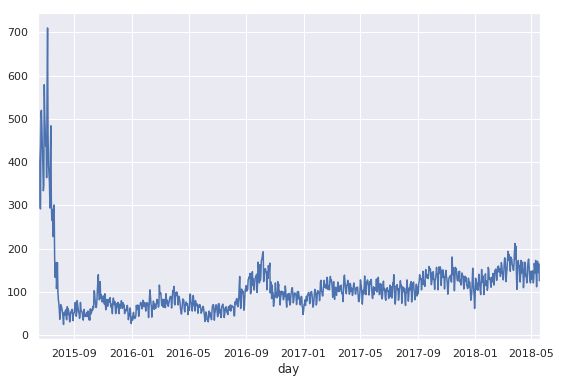

In [12]:
event_data.groupby('day').user_id.nunique().plot()

In [13]:
event_data[event_data.action == 'passed'] \
    .groupby('user_id', as_index=False)\
    .agg({'step_id': 'count'})\
    .rename(columns={'step_id': 'passed_steps'}).passed_steps.min()

1

In [14]:
users_event_data = event_data.pivot_table(index='user_id', 
                       columns='action', 
                       values='step_id', 
                       aggfunc='count', 
                       fill_value=0).reset_index()

In [15]:
users_scores = submissions_data.pivot_table(index='user_id', 
                       columns='submission_status', 
                       values='step_id', 
                       aggfunc='count', 
                       fill_value=0).reset_index()

In [16]:
users_scores.head()

submission_status,user_id,correct,wrong
0,2,2,0
1,3,29,23
2,5,2,2
3,8,9,21
4,14,0,1


In [17]:
gap_data = event_data[['user_id', 'day', 'timestamp']].drop_duplicates(subset=['user_id', 'day'])\
    .groupby('user_id').timestamp.apply(list)\
    .apply(np.diff).values

In [18]:
gap_data = pd.Series(np.concatenate(gap_data, axis=0))

In [19]:
gap_data.quantile(0.90) / (24 * 60 * 60)

18.325995370370403

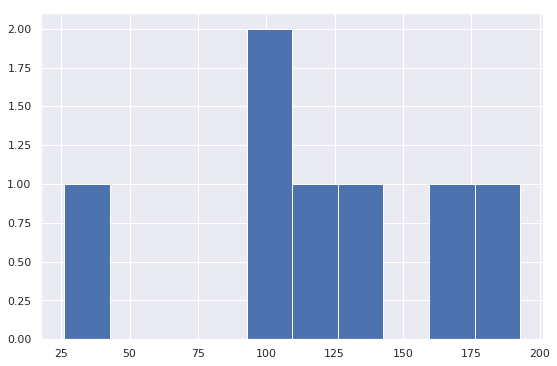

In [20]:
gap_data[gap_data < 200].hist()

In [21]:
users_data = event_data.groupby('user_id', as_index=False).agg({'timestamp': 'max'}).rename(columns={'timestamp': 'last_timestamp'})

In [22]:
30 *24 *60 *60

2592000

In [23]:
now = 1526772811
drop_out_threshold = 2592000

In [24]:
users_data['is_gone_user'] = (now - users_data.last_timestamp) > drop_out_threshold

In [25]:
users_data = users_data.merge(users_scores, how='outer')

In [26]:
users_data = users_data.fillna(0)

In [27]:
users_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong
0,1,1472827464,True,0.0,0.0
1,2,1519226966,True,2.0,0.0
2,3,1444581588,True,29.0,23.0
3,5,1499859939,True,2.0,2.0
4,7,1521634660,True,0.0,0.0


In [28]:
users_data = users_data.merge(users_event_data, how='outer')

In [29]:
users_days = event_data.groupby('user_id').day.nunique().to_frame().reset_index()

In [30]:
users_data = users_data.merge(users_days, how='outer')

In [31]:
users_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day
0,1,1472827464,True,0.0,0.0,1,0,0,1,1
1,2,1519226966,True,2.0,0.0,9,9,2,10,2
2,3,1444581588,True,29.0,23.0,91,87,30,192,7
3,5,1499859939,True,2.0,2.0,11,11,4,12,2
4,7,1521634660,True,0.0,0.0,1,1,0,1,1


In [32]:
users_data["passed_course"] = users_data.passed > 40

In [33]:
users_data.groupby('passed_course').count()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day
passed_course,,,,,,,,,,
False,14596,14596,14596,14596,14596,14596,14596,14596,14596,14596
True,4638,4638,4638,4638,4638,4638,4638,4638,4638,4638


In [34]:
1425 / (1425 + 17809)

0.0740875532910471

In [35]:
users_data.to_csv('users_data.csv')